# Binary BERT Classifier: Neutral vs Emotional
## Chatbot Emotion Detection - Simple Binary Classification

**Objective:**
Train a simple binary BERT classifier to detect if text is **Neutral** or **Emotional** for chatbot purposes.

**Key Configuration:**
- **Task**: Binary Classification (Neutral vs Emotional)
- **Classes**: 
  - **Neutral (0)**: Original neutral class
  - **Emotional (1)**: All 6 Ekman emotions combined (anger, disgust, fear, joy, sadness, surprise)
- **Activation**: Sigmoid for binary output
- **Loss**: BCEWithLogitsLoss or CrossEntropyLoss
- **Labels**: Single integer 0 (neutral) or 1 (emotional)
- **Predictions**: Threshold-based (>0.5 = emotional)
- **Balancing**: NONE - train on original data distribution

**Architecture:**
- Model: BERT-base-uncased (12 layers, 12 heads, 768 hidden)
- Output: 2 neurons (neutral vs emotional)
- Loss: CrossEntropyLoss

**Hyperparameters (Fixed):**
- Learning rate: 2e-5
- Batch size: 32
- Epochs: 50
- Optimizer: AdamW with weight decay 0.01
- Mixed Precision: FP16 for efficiency

**Dataset:**
- GoEmotions dataset
- **Neutral**: Keep as is
- **Emotional**: Combine all 6 Ekman emotions (anger, disgust, fear, joy, sadness, surprise)
- **No balancing/resampling** - use original distribution
- Training/Dev/Test: All keep original distribution

In [3]:
# Step 1: Setup and Imports
import sys
import subprocess

# Install required packages
packages = [
    'transformers',
    'torch',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("✓ All packages installed successfully!")

# Import libraries
import pandas as pd
import numpy as np
import json
import os
import warnings
import re
from collections import Counter
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    BertModel,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,  # ✅ Added for confusion matrix visualization
    hamming_loss,
    f1_score
)

# SMOTE for balancing
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

warnings.filterwarnings('ignore')

# Download NLTK data
print("\nDownloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ NLTK data downloaded")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create results directory
os.makedirs('results', exist_ok=True)
print("✓ Results directory created")

Installing required packages...
✓ All packages installed successfully!

✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created
✓ All packages installed successfully!

✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created


STEP 2: LOADING DATA - BINARY CLASSIFICATION
✓ Loaded 28 original emotions
✓ Binary classification: Neutral (0) vs Emotional (1)
✓ Emotional includes: anger, disgust, fear, joy, sadness, surprise

Loading datasets with binary encoding...
------------------------------------------------------------
------------------------------------------------------------

✓ Train set: 43,410 samples
✓ Dev set: 5,426 samples
✓ Test set: 5,427 samples

BINARY CLASS DISTRIBUTION (No Balancing)

Train Set:
  Neutral   (0): 12,823 (29.54%)
  Emotional (1): 30,587 (70.46%)
  Total        : 43,410

Dev Set:
  Neutral   (0):  1,592 (29.34%)
  Emotional (1):  3,834 (70.66%)
  Total        :  5,426

Test Set:
  Neutral   (0):  1,606 (29.59%)
  Emotional (1):  3,821 (70.41%)
  Total        :  5,427


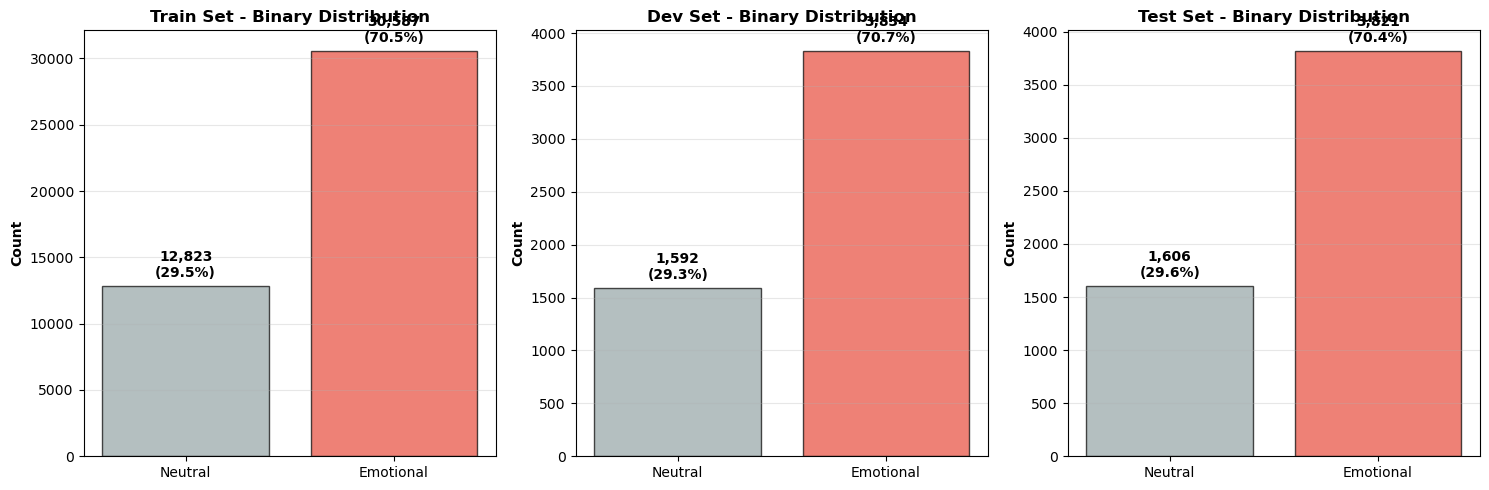


✓ Distribution plot saved to results/binary_distribution_neutral_emotional.png


In [4]:
# Step 2: Load Data for Binary Classification (Neutral vs Emotional)
print("="*60)
print("STEP 2: LOADING DATA - BINARY CLASSIFICATION")
print("="*60)

# Path to data
DATA_PATH = r'../data/'

# Load emotion mappings
with open(f'{DATA_PATH}emotions.txt', 'r', encoding='utf-8') as f:
    emotions = [line.strip() for line in f]

with open(f'{DATA_PATH}ekman_mapping.json', 'r', encoding='utf-8') as f:
    ekman_mapping = json.load(f)

# Create mappings
idx_to_emotion = {i: emotion for i, emotion in enumerate(emotions)}
emotion_to_ekman = {}
for ekman_cat, emotion_list in ekman_mapping.items():
    for emotion in emotion_list:
        emotion_to_ekman[emotion] = ekman_cat
emotion_to_ekman['neutral'] = 'neutral'

# Ekman emotions (will all be labeled as 'emotional')
ekman_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

print(f"✓ Loaded {len(emotions)} original emotions")
print(f"✓ Binary classification: Neutral (0) vs Emotional (1)")
print(f"✓ Emotional includes: {', '.join(ekman_emotions)}")

def encode_binary_neutral_emotional(emotions_str):
    """
    Convert emotion string to binary label:
    - 0 = Neutral (only neutral emotion)
    - 1 = Emotional (any Ekman emotion present)
    """
    if pd.notna(emotions_str) and emotions_str.strip():
        # Parse emotion indices
        emotion_ids = [int(e) for e in str(emotions_str).split(',')]
        
        # Check if any emotion is an Ekman emotion (non-neutral)
        for eid in emotion_ids:
            if eid < len(idx_to_emotion):
                emotion_name = idx_to_emotion[eid]
                ekman_emotion = emotion_to_ekman.get(emotion_name, 'neutral')
                
                # If any Ekman emotion found, it's emotional
                if ekman_emotion in ekman_emotions:
                    return 1  # Emotional
        
        # If only neutral emotions found
        return 0  # Neutral
    
    # Default to neutral if empty
    return 0

def load_data(path):
    """Load TSV data with binary encoding (neutral=0, emotional=1)"""
    df = pd.read_csv(path, sep='\t', header=None, names=['text', 'labels', 'id'])
    
    # Encode to binary label (0=neutral, 1=emotional)
    df['label'] = df['labels'].apply(encode_binary_neutral_emotional)
    
    # Map to class names for visualization
    df['class'] = df['label'].map({0: 'neutral', 1: 'emotional'})
    
    return df

# Load datasets
print("\nLoading datasets with binary encoding...")
print("-" * 60)
train_df = load_data(f'{DATA_PATH}train.tsv')
dev_df = load_data(f'{DATA_PATH}dev.tsv')
test_df = load_data(f'{DATA_PATH}test.tsv')
print("-" * 60)

print(f"\n✓ Train set: {len(train_df):,} samples")
print(f"✓ Dev set: {len(dev_df):,} samples")
print(f"✓ Test set: {len(test_df):,} samples")

# Display distribution
print("\n" + "="*60)
print("BINARY CLASS DISTRIBUTION (No Balancing)")
print("="*60)

for name, df in [('Train', train_df), ('Dev', dev_df), ('Test', test_df)]:
    neutral_count = (df['label'] == 0).sum()
    emotional_count = (df['label'] == 1).sum()
    total = len(df)
    
    neutral_pct = (neutral_count / total) * 100
    emotional_pct = (emotional_count / total) * 100
    
    print(f"\n{name} Set:")
    print(f"  Neutral   (0): {neutral_count:6,} ({neutral_pct:5.2f}%)")
    print(f"  Emotional (1): {emotional_count:6,} ({emotional_pct:5.2f}%)")
    print(f"  Total        : {total:6,}")

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#95a5a6', '#e74c3c']  # Gray for neutral, Red for emotional
class_labels = ['Neutral', 'Emotional']

for ax_idx, (name, df) in enumerate([('Train', train_df), ('Dev', dev_df), ('Test', test_df)]):
    counts = df['label'].value_counts().sort_index()
    counts_ordered = [counts.get(i, 0) for i in [0, 1]]
    
    bars = axes[ax_idx].bar(class_labels, counts_ordered, color=colors, alpha=0.7, edgecolor='black')
    axes[ax_idx].set_title(f'{name} Set - Binary Distribution', fontweight='bold')
    axes[ax_idx].set_ylabel('Count', fontweight='bold')
    axes[ax_idx].grid(axis='y', alpha=0.3)
    
    # Add percentage labels
    total = len(df)
    for j, count in enumerate(counts_ordered):
        if count > 0:
            pct = (count / total) * 100
            axes[ax_idx].text(j, count + total*0.01, f'{count:,}\n({pct:.1f}%)',
                            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('results/binary_distribution_neutral_emotional.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Distribution plot saved to results/binary_distribution_neutral_emotional.png")

In [5]:
# Step 3: BERT Dataset and DataLoader Setup
print("="*60)
print("STEP 3: BERT DATASET & DATALOADER SETUP")
print("="*60)

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("✓ Tokenizer loaded: bert-base-uncased")

class BertBinaryDataset(Dataset):
    """BERT Dataset for binary classification (neutral vs emotional)"""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(df_train, df_dev, df_test, tokenizer, batch_size=32):
    """Create DataLoaders for train, dev, and test sets"""
    train_dataset = BertBinaryDataset(
        texts=df_train['text'].values,
        labels=df_train['label'].values,
        tokenizer=tokenizer
    )

    dev_dataset = BertBinaryDataset(
        texts=df_dev['text'].values,
        labels=df_dev['label'].values,
        tokenizer=tokenizer
    )

    test_dataset = BertBinaryDataset(
        texts=df_test['text'].values,
        labels=df_test['label'].values,
        tokenizer=tokenizer
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, dev_loader, test_loader

print("✓ BERT Binary Dataset class defined")
print("✓ DataLoader creation function ready")
print("✓ No preprocessing or balancing - using original data")


STEP 3: BERT DATASET & DATALOADER SETUP
✓ Tokenizer loaded: bert-base-uncased
✓ BERT Binary Dataset class defined
✓ DataLoader creation function ready
✓ No preprocessing or balancing - using original data
✓ Tokenizer loaded: bert-base-uncased
✓ BERT Binary Dataset class defined
✓ DataLoader creation function ready
✓ No preprocessing or balancing - using original data


In [6]:
# Step 4: Training Functions (Fixed Hyperparameters)
print("="*60)
print("STEP 4: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS)")
print("="*60)

from torch.cuda.amp import autocast, GradScaler

# Fixed hyperparameters
FIXED_PARAMS = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'epochs': 50,
    'weight_decay': 0.01
}

print(f"Fixed Hyperparameters:")
print(f"  Learning Rate: {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size: {FIXED_PARAMS['batch_size']}")
print(f"  Epochs: {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay: {FIXED_PARAMS['weight_decay']}")
print(f"  Optimizer: AdamW")
print(f"  Loss: CrossEntropyLoss (no weights)")
print(f"  Architecture: BERT (12 layers, 12 heads, hidden=768)")

def train_epoch_amp(model, data_loader, optimizer, scheduler, device, scaler):
    """Training loop with automatic mixed precision"""
    model.train()
    total_loss = 0.0
    predictions, true_labels = [], []

    for batch in data_loader:
        optimizer.zero_grad(set_to_none=True)

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        with autocast():
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.detach().cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy

def evaluate_model_amp(model, data_loader, device):
    """Evaluation with automatic mixed precision"""
    model.eval()
    predictions, true_labels = [], []

    with torch.no_grad(), autocast():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).detach().cpu().numpy()

            predictions.extend(preds)
            true_labels.extend(labels.detach().cpu().numpy())

            del input_ids, attention_mask, labels, outputs, logits
            torch.cuda.empty_cache()

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    accuracy = accuracy_score(true_labels, predictions)

    return predictions, true_labels, precision, recall, f1, accuracy

print("✓ Training and evaluation functions defined")
print("✓ Mixed precision (FP16) enabled for efficiency")


STEP 4: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS)
Fixed Hyperparameters:
  Learning Rate: 2e-05
  Batch Size: 32
  Epochs: 50
  Weight Decay: 0.01
  Optimizer: AdamW
  Loss: CrossEntropyLoss (no weights)
  Architecture: BERT (12 layers, 12 heads, hidden=768)
✓ Training and evaluation functions defined
✓ Mixed precision (FP16) enabled for efficiency


In [7]:
# Step 5: Train Binary Model (Neutral vs Emotional)
print("="*60)
print("STEP 5: TRAINING BINARY CLASSIFIER (NEUTRAL VS EMOTIONAL)")
print("="*60)

# Create data loaders
train_loader, dev_loader, test_loader = create_data_loaders(
    train_df, dev_df, test_df,
    tokenizer,
    batch_size=FIXED_PARAMS['batch_size']
)

print(f"✓ Data loaders created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Dev batches: {len(dev_loader)}")
print(f"  Test batches: {len(test_loader)}")

# Initialize model (2 classes: neutral=0, emotional=1)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2
)
model = model.to(device)

print(f"\n✓ Model initialized: BERT-base-uncased")
print(f"  Output classes: 2 (Neutral, Emotional)")
print(f"  Parameters: ~110M")

# Optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=FIXED_PARAMS['learning_rate'],
    weight_decay=FIXED_PARAMS['weight_decay'],
    eps=1e-8
)

total_steps = len(train_loader) * FIXED_PARAMS['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

scaler = GradScaler()

print(f"✓ Optimizer: AdamW (LR={FIXED_PARAMS['learning_rate']})")
print(f"✓ Scheduler: Linear warmup")
print(f"✓ Mixed precision: Enabled")

# Training loop
print(f"\nStarting training for {FIXED_PARAMS['epochs']} epochs...")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Dev Macro-F1':<12} {'Status'}")
print("-" * 60)

best_f1 = 0
best_epoch = 0
best_model_state = None

history = {
    'train_loss': [],
    'train_acc': [],
    'dev_macro_f1': [],
    'dev_accuracy': []
}

for epoch in range(FIXED_PARAMS['epochs']):
    # Training
    train_loss, train_acc = train_epoch_amp(
        model, train_loader, optimizer, scheduler, device, scaler
    )
    
    # Validation
    _, _, _, _, dev_f1, dev_acc = evaluate_model_amp(model, dev_loader, device)
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['dev_macro_f1'].append(dev_f1)
    history['dev_accuracy'].append(dev_acc)
    
    # Track best model
    status = ""
    if dev_f1 > best_f1:
        best_f1 = dev_f1
        best_epoch = epoch + 1
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        status = "⭐ BEST"
    
    # Print progress every 5 epochs or if best
    if (epoch + 1) % 5 == 0 or status:
        print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {dev_f1:<12.4f} {status}")

print("-" * 60)
print(f"✓ Training completed! Best epoch: {best_epoch} (Dev Macro-F1: {best_f1:.4f})")

# Load best model and evaluate on test set
if best_model_state:
    model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

print(f"\nEvaluating on test set...")
test_preds, test_labels, test_precision, test_recall, test_f1, test_acc = evaluate_model_amp(
    model, test_loader, device
)

print(f"\nTest Set Results:")
print(f"  Macro-F1:   {test_f1:.4f}")
print(f"  Accuracy:   {test_acc:.4f}")
print(f"  Precision:  {test_precision:.4f}")
print(f"  Recall:     {test_recall:.4f}")

# Per-class metrics
print(f"\nPer-Class Metrics:")
for class_idx, class_name in enumerate(['Neutral', 'Emotional']):
    class_mask = [label == class_idx for label in test_labels]
    class_preds = [test_preds[i] for i, mask in enumerate(class_mask) if mask]
    class_true = [test_labels[i] for i, mask in enumerate(class_mask) if mask]
    
    if class_true:
        prec, rec, f1, _ = precision_recall_fscore_support(
            class_true, class_preds, average='binary', pos_label=class_idx, zero_division=0
        )
        acc = accuracy_score(class_true, class_preds)
        print(f"  {class_name:10s}: F1={f1:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, Acc={acc:.4f}")

# Save model
os.makedirs('results', exist_ok=True)
torch.save(best_model_state, 'results/best_model_neutral_emotional.pt')
print(f"\n✓ Model saved to results/best_model_neutral_emotional.pt")

# Store results
binary_result = {
    'params': FIXED_PARAMS,
    'best_epoch': best_epoch,
    'dev_macro_f1': best_f1,
    'test_macro_f1': test_f1,
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'history': history,
    'test_predictions': test_preds,
    'test_labels': test_labels
}

print(f"\n{'='*60}")
print("BINARY CLASSIFICATION COMPLETED")
print(f"{'='*60}")


STEP 5: TRAINING BINARY CLASSIFIER (NEUTRAL VS EMOTIONAL)
✓ Data loaders created
  Train batches: 1357
  Dev batches: 170
  Test batches: 170


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model initialized: BERT-base-uncased
  Output classes: 2 (Neutral, Emotional)
  Parameters: ~110M
✓ Optimizer: AdamW (LR=2e-05)
✓ Scheduler: Linear warmup
✓ Mixed precision: Enabled

Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev Macro-F1 Status
------------------------------------------------------------
1        0.4892       0.7498       0.7342       ⭐ BEST
1        0.4892       0.7498       0.7342       ⭐ BEST
3        0.4070       0.8051       0.7410       ⭐ BEST
3        0.4070       0.8051       0.7410       ⭐ BEST
5        0.3259       0.8560       0.7229       
5        0.3259       0.8560       0.7229       
10       0.1540       0.9414       0.6990       
10       0.1540       0.9414       0.6990       
15       0.0962       0.9753       0.6971       
15       0.0962       0.9753       0.6971       
20       0.1132       0.9860       0.6848       
20       0.1132       0.9860       0.6848       
25       0.0796       0.9905       0.6820       
25

STEP 6: RESULTS VISUALIZATION


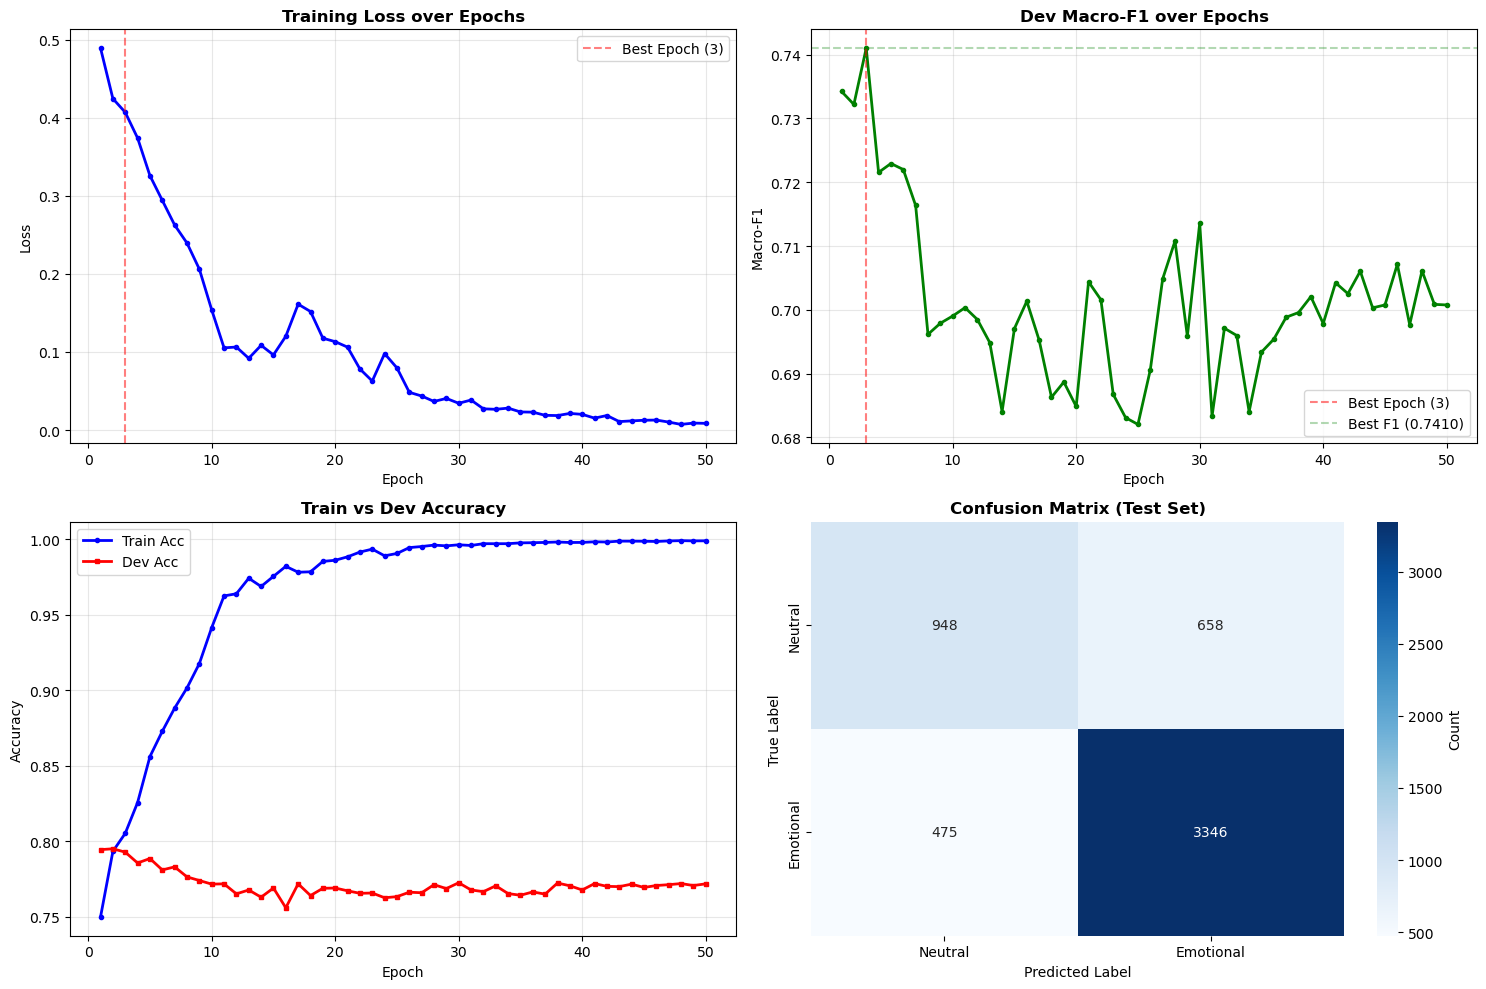

✓ Training plots saved to results/binary_training_results.png

DETAILED CLASSIFICATION REPORT

              precision    recall  f1-score   support

     Neutral     0.6662    0.5903    0.6259      1606
   Emotional     0.8357    0.8757    0.8552      3821

    accuracy                         0.7912      5427
   macro avg     0.7509    0.7330    0.7406      5427
weighted avg     0.7855    0.7912    0.7874      5427



In [8]:
# Step 6: Visualize Results and Confusion Matrix
print("="*60)
print("STEP 6: RESULTS VISUALIZATION")
print("="*60)

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Training loss
epochs_range = range(1, len(history['train_loss']) + 1)
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-', linewidth=2, marker='o', markersize=3)
axes[0, 0].set_title('Training Loss over Epochs', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0, 0].legend()

# 2. Dev Macro-F1
axes[0, 1].plot(epochs_range, history['dev_macro_f1'], 'g-', linewidth=2, marker='o', markersize=3)
axes[0, 1].set_title('Dev Macro-F1 over Epochs', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Macro-F1')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
axes[0, 1].axhline(y=best_f1, color='green', linestyle='--', alpha=0.3, label=f'Best F1 ({best_f1:.4f})')
axes[0, 1].legend()

# 3. Accuracy comparison
train_acc_plot = history['train_acc']
dev_acc_plot = history['dev_accuracy']
axes[1, 0].plot(epochs_range, train_acc_plot, 'b-', linewidth=2, marker='o', markersize=3, label='Train Acc')
axes[1, 0].plot(epochs_range, dev_acc_plot, 'r-', linewidth=2, marker='s', markersize=3, label='Dev Acc')
axes[1, 0].set_title('Train vs Dev Accuracy', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# 4. Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Neutral', 'Emotional'],
            yticklabels=['Neutral', 'Emotional'],
            ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Confusion Matrix (Test Set)', fontweight='bold')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/binary_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training plots saved to results/binary_training_results.png")

# Classification report
print(f"\n{'='*60}")
print("DETAILED CLASSIFICATION REPORT")
print(f"{'='*60}")
from sklearn.metrics import classification_report
print("\n" + classification_report(test_labels, test_preds, 
                                   target_names=['Neutral', 'Emotional'], 
                                   digits=4))

print(f"{'='*60}")


In [10]:
# Step 7: Export Results for Chatbot Integration
print("="*60)
print("STEP 7: EXPORT RESULTS FOR CHATBOT INTEGRATION")
print("="*60)

# Export to JSON
export_data = {
    'model_info': {
        'type': 'binary_classifier',
        'task': 'neutral_vs_emotional_detection',
        'architecture': 'BERT-base-uncased',
        'num_classes': 2,
        'class_names': ['neutral', 'emotional'],
        'date_trained': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    },
    'hyperparameters': FIXED_PARAMS,
    'training_results': {
        'best_epoch': best_epoch,
        'dev_macro_f1': float(best_f1),
        'test_macro_f1': float(test_f1),
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall)
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'dev_samples': len(dev_df),
        'test_samples': len(test_df),
        'train_neutral': int((train_df['label'] == 0).sum()),
        'train_emotional': int((train_df['label'] == 1).sum()),
        'test_neutral': int(sum(1 for label in test_labels if label == 0)),
        'test_emotional': int(sum(1 for label in test_labels if label == 1))
    },
    'usage_guide': {
        'purpose': 'Detect if user input is neutral or emotional for chatbot routing',
        'threshold': 0.5,
        'classes': {
            '0': 'neutral - factual queries, information requests',
            '1': 'emotional - contains anger, disgust, fear, joy, sadness, or surprise'
        },
        'example_use_cases': [
            'Route emotional messages to empathetic response handler',
            'Trigger sentiment-appropriate responses',
            'Escalate highly emotional inputs to human agents',
            'Maintain neutral tone for factual queries'
        ]
    }
}

# Save JSON
json_path = 'results/neutral_emotional_classifier_results.json'
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Results exported to {json_path}")

# Save confusion matrix data
cm_data = {
    'confusion_matrix': cm.tolist(),
    'class_labels': ['neutral', 'emotional'],
    'metrics_per_class': {}
}

for class_idx, class_name in enumerate(['neutral', 'emotional']):
    class_mask = [label == class_idx for label in test_labels]
    class_preds = [test_preds[i] for i, mask in enumerate(class_mask) if mask]
    class_true = [test_labels[i] for i, mask in enumerate(class_mask) if mask]
    
    if class_true:
        prec, rec, f1, _ = precision_recall_fscore_support(
            class_true, class_preds, average='binary', pos_label=class_idx, zero_division=0
        )
        cm_data['metrics_per_class'][class_name] = {
            'precision': float(prec),
            'recall': float(rec),
            'f1_score': float(f1),
            'support': len(class_true)
        }

with open('results/confusion_matrix_data.json', 'w') as f:
    json.dump(cm_data, f, indent=2)

print(f"✓ Confusion matrix data saved to results/confusion_matrix_data.json")

# Quick reference guide
print(f"\n{'='*60}")
print("CHATBOT INTEGRATION QUICK REFERENCE")
print(f"{'='*60}")
print("\n📝 Model Usage:")
print("  1. Load model: BertForSequenceClassification.from_pretrained(model_path)")
print("  2. Tokenize input: tokenizer(text, max_length=128, ...)")
print("  3. Get prediction: argmax(model(input_ids).logits)")
print("  4. Interpret: 0 = Neutral, 1 = Emotional")

print("\n🎯 Performance Summary:")
print(f"  Test Accuracy:  {test_acc:.2%}")
print(f"  Test Macro-F1:  {test_f1:.4f}")
print(f"  Best Epoch:     {best_epoch}/{ FIXED_PARAMS['epochs']}")

print("\n💡 Use Cases:")
print("  • Chatbot emotion detection")
print("  • Automatic routing based on user emotion")
print("  • Trigger empathetic responses")
print("  • Filter emotional vs neutral queries")

print(f"\n{'='*60}")
print("✅ EXPORT COMPLETED - READY FOR CHATBOT DEPLOYMENT")
print(f"{'='*60}")


STEP 7: EXPORT RESULTS FOR CHATBOT INTEGRATION
✓ Results exported to results/neutral_emotional_classifier_results.json
✓ Confusion matrix data saved to results/confusion_matrix_data.json

CHATBOT INTEGRATION QUICK REFERENCE

📝 Model Usage:
  1. Load model: BertForSequenceClassification.from_pretrained(model_path)
  2. Tokenize input: tokenizer(text, max_length=128, ...)
  3. Get prediction: argmax(model(input_ids).logits)
  4. Interpret: 0 = Neutral, 1 = Emotional

🎯 Performance Summary:
  Test Accuracy:  79.12%
  Test Macro-F1:  0.7406
  Best Epoch:     3/50

💡 Use Cases:
  • Chatbot emotion detection
  • Automatic routing based on user emotion
  • Trigger empathetic responses
  • Filter emotional vs neutral queries

✅ EXPORT COMPLETED - READY FOR CHATBOT DEPLOYMENT


In [12]:
# Step 8: Test the Model with Sample Queries
print("="*60)
print("STEP 8: INTERACTIVE MODEL TESTING")
print("="*60)

def predict_emotion(text, model, tokenizer, device):
    """
    Predict if text is neutral or emotional
    Returns: prediction label, class name, and confidence scores
    """
    model.eval()
    
    # Tokenize input
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Get prediction
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(logits, dim=1).item()
        confidence = probs[0][prediction].item()
    
    class_name = 'Neutral' if prediction == 0 else 'Emotional'
    
    return {
        'text': text,
        'prediction': prediction,
        'class': class_name,
        'confidence': confidence,
        'neutral_prob': probs[0][0].item(),
        'emotional_prob': probs[0][1].item()
    }

# Test queries covering different scenarios
test_queries = [
    # Neutral examples
    "What time does the store open?",
    "I need information about the product specifications.",
    "Can you tell me the weather forecast?",
    "The meeting is scheduled for 3 PM tomorrow.",
    
    # Emotional examples - Joy
    "I'm so happy with this purchase! Thank you!",
    "This is amazing! Best day ever!",
    
    # Emotional examples - Anger
    "I'm really frustrated with this service!",
    "This is unacceptable! I want a refund now!",
    
    # Emotional examples - Sadness
    "I'm disappointed with the results.",
    "This makes me feel really down.",
    
    # Emotional examples - Fear
    "I'm worried this won't work.",
    "This is scary, I don't know what to do.",
    
    # Emotional examples - Surprise
    "Wow! I didn't expect that at all!",
    "I can't believe this happened!",
    "I am really sad today. I dont know what to do. My parents are divorced. I want to cry. At the same time i am also hungry"
]

print("\n" + "="*60)
print("TESTING MODEL WITH SAMPLE QUERIES")
print("="*60)

results = []
for query in test_queries:
    result = predict_emotion(query, model, tokenizer, device)
    results.append(result)
    
    # Color coding for better visualization
    if result['class'] == 'Neutral':
        emoji = "😐"
        color = "NEUTRAL"
    else:
        emoji = "😊😠😢😨"
        color = "EMOTIONAL"
    
    print(f"\n{emoji} Text: {result['text']}")
    print(f"   Prediction: {result['class']} ({color})")
    print(f"   Confidence: {result['confidence']:.2%}")
    print(f"   Probabilities: Neutral={result['neutral_prob']:.2%}, Emotional={result['emotional_prob']:.2%}")

# Summary statistics
print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)

neutral_count = sum(1 for r in results if r['prediction'] == 0)
emotional_count = sum(1 for r in results if r['prediction'] == 1)

print(f"\nTotal queries tested: {len(results)}")
print(f"Predicted as Neutral: {neutral_count} ({neutral_count/len(results)*100:.1f}%)")
print(f"Predicted as Emotional: {emotional_count} ({emotional_count/len(results)*100:.1f}%)")

# Calculate average confidence
avg_confidence = sum(r['confidence'] for r in results) / len(results)
print(f"\nAverage confidence: {avg_confidence:.2%}")

# Show high and low confidence predictions
print("\n" + "-"*60)
print("Highest Confidence Predictions:")
sorted_by_conf = sorted(results, key=lambda x: x['confidence'], reverse=True)
for i, r in enumerate(sorted_by_conf[:3], 1):
    print(f"{i}. [{r['class']}] \"{r['text'][:50]}...\" ({r['confidence']:.2%})")

print("\n" + "-"*60)
print("Lowest Confidence Predictions:")
for i, r in enumerate(sorted_by_conf[-3:], 1):
    print(f"{i}. [{r['class']}] \"{r['text'][:50]}...\" ({r['confidence']:.2%})")

print("\n" + "="*60)
print("✅ INTERACTIVE TESTING COMPLETED")
print("="*60)
print("\n💡 Try your own queries:")
print("   result = predict_emotion('Your text here', model, tokenizer, device)")
print("   print(f\"Prediction: {result['class']} ({result['confidence']:.2%})\")")


STEP 8: INTERACTIVE MODEL TESTING

TESTING MODEL WITH SAMPLE QUERIES

😊😠😢😨 Text: What time does the store open?
   Prediction: Emotional (EMOTIONAL)
   Confidence: 56.95%
   Probabilities: Neutral=43.05%, Emotional=56.95%

😐 Text: I need information about the product specifications.
   Prediction: Neutral (NEUTRAL)
   Confidence: 57.16%
   Probabilities: Neutral=57.16%, Emotional=42.84%

😊😠😢😨 Text: Can you tell me the weather forecast?
   Prediction: Emotional (EMOTIONAL)
   Confidence: 68.05%
   Probabilities: Neutral=31.95%, Emotional=68.05%

😐 Text: The meeting is scheduled for 3 PM tomorrow.
   Prediction: Neutral (NEUTRAL)
   Confidence: 80.72%
   Probabilities: Neutral=80.72%, Emotional=19.28%

😊😠😢😨 Text: I'm so happy with this purchase! Thank you!
   Prediction: Emotional (EMOTIONAL)
   Confidence: 99.65%
   Probabilities: Neutral=0.35%, Emotional=99.65%

😊😠😢😨 Text: This is amazing! Best day ever!
   Prediction: Emotional (EMOTIONAL)
   Confidence: 99.71%
   Probabilities: Neutr